In [107]:
import pandas as pd
import numpy as np
import networkx as nx
import hydrant.topology.geom as gm
import matplotlib.pyplot as plt
from typing import (
    Union,
    List
)
from __future__ import annotations

def find_upstream(
    gdf: gpd.GeoDataFrame,
    target_id: Union[str, int, ...],
    main_id: str,
    ds_main_id: str,
) -> set[...]:
    '''Find "ancestors" or upstream segments in a river network given
    in the from of a geopandas.GeoDataFrame `gdf`
    
    Parameters
    ----------
    gdf: geopandas.GeoDataFrame
        GeoDataFrame of river segments including at least three pieces
        of information: 1) geometries of segments, 2) segment IDs, and
        3) downstream segment IDs
    target_id: str, int, or any other data type as included in `gdf`
        Indicating the target ID anscestor or upstream of which is
        desired
    main_id: str
        String defining the column of element IDs in the input geopandas
        dataframe
    ds_main_id: str
        String defining the column of downstream element IDs in the
        input geopandas dataframe
    
    Returns
    -------
    nodes: list
        IDs of nodes being upstream or anscestor of the `target_id`
    
    '''
    # creating a DiGraph out of `gdf` object
    riv_graph = nx.from_pandas_edgelist(gdf,
                                        source=main_id,
                                        target=ds_main_id,
                                        create_using=nx.DiGraph)

    # return nodes in a list
    nodes = nx.ancestors(riv_graph, target_id)

    # adding `target_id` as the last node of the branch
    nodes.add(target_id)

    return nodes

def main_branch(df):
    
    # Create a directed graph
    G = nx.DiGraph()

    # Add edges and assign upa as edge weight
    for _, row in df.iterrows():
        G.add_edge(row['next'], row['id'], weight=row['upa'])
        
    # get the longest distance weighted based on up area
    longest_path = nx.dag_longest_path(G, weight='weight')

    #print("Longest distance:", longest_path)
    
    # Set flag to 1 where id is in the array_to_check
    df ['main_branch'] = 0
    df.loc[df['id'].isin(longest_path), 'main_branch'] = 1
    
    return df

def pfaf_one_round(df):
    
    df['pfaf_temp'] = 1
    df = main_branch(df)
    
    #print('df',df)
    
    # Separate DataFrame based on flag value
    df_main      = df[df['main_branch'] == 1].sort_values(by='upa', ignore_index=True)
    
    #print('length df', len(df))
    #print('length df_main', len(df_main))
    
    if len(df) != len(df_main):
        
        # identify 4 largest upstream segments to main branch
        df_none_main = df[df['main_branch'] == 0].sort_values(by='upa', ignore_index=True, ascending=False)
        max_4_up = df_none_main.loc[df_none_main['next'].isin(df_main['id'])].head(4)
        max_4_up = max_4_up.sort_values(by='upa', ignore_index=True)

        # attach the uparea of the next down ID, which are on main ID, to the max_4_up dataframe
        max_4_up ['next_up_area'] = 0
        max_4_up ['up_confluence_main_id'] = 0
        for index, row in max_4_up.iterrows():
            # get the up area of df_main that is downstream of max_4_up
            max_4_up.loc[index,'next_up_area'] = df_main['upa'].loc[df_main['id']==row['next']].values
            index_temp = df_main.loc[df_main['id']==row['next']].index-1
            index_temp = np.array(index_temp).item()
            max_4_up.loc[index,'up_confluence_main_id'] = df_main['id'].loc[index_temp] #.loc[df_main.loc[df_main['id']==row['next']].index.values+1]

        max_4_up = max_4_up.sort_values(by='next_up_area', ignore_index=True)
        
        #print('df')
        #print(df)
        #print('df_main')
        #print(df_main)
        #print('max_4_up')
        #print(max_4_up)
        
        if max_4_up.empty:
            
            # print('max_4_up is empty')
            ll

        # get the len of max_4_up unique elements
        if len(np.unique(max_4_up['next'])) == 4:
            odd_pfafs = [3,5,7,9]
        elif len(np.unique(max_4_up['next'])) == 3:
            odd_pfafs = [3,5,9]
        elif len(np.unique(max_4_up['next'])) == 2:
            odd_pfafs = [3,9]
        elif len(np.unique(max_4_up['next'])) == 1:
            odd_pfafs = [9]

        # get the len of max_4_up elements
        if len(max_4_up['next']) == 4:
            even_pfafs = [2,4,6,8]
        elif len(max_4_up['next']) == 3:
            even_pfafs = [2,4,6]
        elif len(max_4_up['next']) == 2:
            even_pfafs = [2,4]
        elif len(max_4_up['next']) == 1:
            even_pfafs = [2]

        # loop over the df_main from downstream to upstream and capture the id and their 
        # pfaf digit from 1 as the most downstream segment
        #for index, rows in df_main.itterrows():
            # get the 
        #print(df_main)
        #print(df_none_main)
        #print(max_4_up)
        #print(even_pfafs)
        #print(odd_pfafs)

        # add the segment and station into a data frame
        seg_ids = np.array([])
        pfaf_codes = np.array([])

        # Add values to the array for main branch
        seg_ids = np.append(seg_ids, max_4_up['up_confluence_main_id'])
        pfaf_codes = np.append(pfaf_codes, np.flip(odd_pfafs, axis=0))

        # add values to array for tributaries
        seg_ids = np.append(seg_ids, max_4_up['id'])
        pfaf_codes = np.append(pfaf_codes, np.flip(even_pfafs, axis=0))


        #print(seg_ids)
        #print(pfaf_codes)

        zipped = zip(seg_ids, pfaf_codes)
        sorted_zipped = sorted(zipped, key=lambda x: x[1])

        #print(sorted_zipped)


        # get the upstream and assign the pfaf from smaller values to largest values
        df ['pfaf_temp'] = 1

        for seg_id, pfaf_code in sorted_zipped:
            ids_selected = find_upstream(df, seg_id, 'id', 'next')
            # replace the ids in df
            indices = df[df['id'].isin(ids_selected)].index
            # Update 'flag' column to 1 for the rows with matching indices
            df.loc[indices, 'pfaf_temp'] = pfaf_code

    return df # seg_ids, pfaf_codes


def pfaf(df):
    
    
    
    # initial pfaf set up for the df
    df = pfaf_one_round (df)
    df ['pfaf'] = df ['pfaf_temp']
    
    
    for i in np.arange(2, 10):
        
        if len(df) != len(np.unique(df ['pfaf'])):
        
            df_slice_total = pd.DataFrame()

            for m in np.unique(df ['pfaf']):

                df_slice = df[df['pfaf']==m]
                df_slice = pfaf_one_round(df_slice)
                df_slice_total = pd.concat([df_slice_total,df_slice], ignore_index=True)

            df = df_slice_total.copy()

            #print(df)
        else:
            
            df['pfaf_temp'] = 0

        # Convert values in column1 and column2 to strings
        df['pfaf'] = df['pfaf'].astype(str)
        df['pfaf_temp'] = df['pfaf_temp'].astype(str)

        # Concatenate the strings in column1 and column2
        df['pfaf'] = df['pfaf'] + df['pfaf_temp']

        # Convert the concatenated string back to integers
        df['pfaf'] = df['pfaf'].astype(int)

        #print(df)
        

#     df ['pfaf_temp'] = 1

#     for i in np.arange(1, 4):

#         df_slice_total = pd.DataFrame()

#         # slice the df based on unique values in pfaf_temp
#         for m in np.unique(df['pfaf_temp']):

#             df_slice = df[df['pfaf_temp']==m]
#             df_slice = main_branch(df_slice)
#             df_slice = pfaf_one_round(df_slice)

#             df_slice_total = pd.concat([df_slice_total,df_slice], ignore_index=True)

#         df = df_slice_total.copy()
        
#         if df['pfaf_temp'].prod() == 1:
#             break
#         else:
#             temp_name = 'pfaf_'+str(i)
#             df [temp_name] = df ['pfaf_temp']
        
        

#         print(df)
        
    return df

    
# # Example data
# data = {
#     'id':   [1, 2, 3, 4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
#     'next': [6, 6, 5, 5,  6,  8,  8, 11, 10, 11, 13, 13, -9],
#     'upa':  [5, 5, 5, 5, 13, 26,  5, 29,  5,  8, 40,  5, 48],
#     'a':    [5, 5, 5, 5,  3,  3,  5,  3,  5,  3,  3,  5,  3]
# }

# Example data
data = {
    'id':   [1, 2, 3, 4,  5,  6,  7],
    'next': [3, 3, 5, 5,  7,  7,  8],
    'a':    [2, 3, 1, 6,  2,  7,  7],
    'upa':  [2, 3, 6, 6, 14,  7, 28],
}

# # Example data
# data = {
#     'id':   [1, 2, 3],
#     'next': [3, 3, 5],
#     'a':    [2, 3, 1],
#     'upa':  [2, 3, 6],
# }

# Create DataFrame
df = pd.DataFrame(data)

# Traverse upstream using NetworkX
# df = main_branch(df)

# pfaf_one_round(df)

df = pfaf(df)

df

,id,next,a,upa,pfaf_temp,main_branch,pfaf
0,1,3,2,2,0,0,600000000
1,2,3,3,3,0,1,900000000
2,3,5,1,6,0,1,500000000
3,4,5,6,6,0,0,400000000
4,5,7,2,14,0,1,300000000
5,6,7,7,7,0,0,200000000
6,7,8,7,28,0,1,100000000


/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to b

<AxesSubplot:>

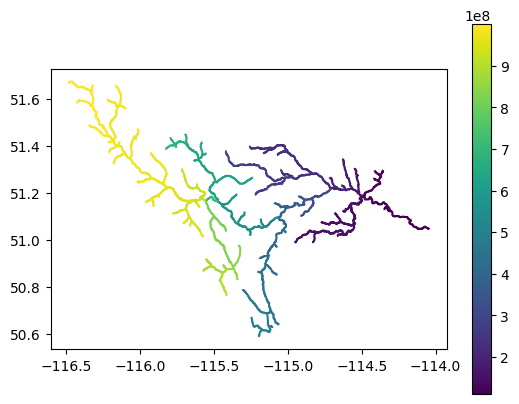

In [108]:
import geopandas as gpd

riv = gpd.read_file('../examples/output/stations_merit_riv.shp')
cat = gpd.read_file('../examples/output/stations_merit_cat.shp')

riv = riv.rename(columns={'COMID': 'id', 'NextDownID': 'next', 'uparea': 'upa', 'unitarea': 'a'})
cat = cat.rename(columns={'COMID': 'id'})

# riv = main_branch(riv)

riv = pfaf(riv)


# # Create a new figure and axes
fig, ax = plt.subplots()

# Plot the first river GeoDataFrame
riv.plot(column='pfaf', cmap='viridis', legend=True, ax=ax)

In [ ]:
import geopandas as gpd

riv = gpd.read_file('../examples/output/stations_merit_riv.shp')
cat = gpd.read_file('../examples/output/stations_merit_cat.shp')

riv = riv.rename(columns={'COMID': 'id', 'NextDownID': 'next', 'uparea': 'upa', 'unitarea': 'a'})
cat = cat.rename(columns={'COMID': 'id'})

riv = main_branch(riv)



riv = pfaf_one_round(riv)

# #[71028585. 71028189. 71028054. 71028007. 71028221. 71029118. 71028249. 71028757.]
# #[       9.        7.        5.        3.        8.        6.        4.        2.]


# # slice the domain for various stations and their seg ID
# cat_slice, riv_slice = gm.subset_ntopo(cat=cat,\
#                                        cat_cols={'id':'id'},\
#                                        riv=riv,\
#                                        riv_cols={'id':'id', 'next_id':'next'},\
#                                        outlet_id=[71028585])

# # Create a new figure and axes
fig, ax = plt.subplots()

# Plot the first river GeoDataFrame
riv.plot(column='pfaf_temp', cmap='viridis', legend=True, ax=ax)

# # Plot the second river GeoDataFrame on the same axes
# riv_slice.plot(ax=ax)

riv.to_file('./output/stations_merit_riv_pfaf.shp')



12
14
3
11
         id   lengthkm  lengthdir  sinuosity     slope         upa  order  \
0  71029992  19.922125  15.386958   1.294741  0.012642  302.561930      2   
1  71030100   7.025087   5.644826   1.244518  0.033148  149.821056      2   
2  71029798   5.772684   4.297190   1.343363  0.015809  239.968783      2   
3  71029857  10.522295   5.473662   1.922350  0.017815  151.923871      2   

   strmDrop_t  slope_taud      next  ...  hillslope          a   latitude  \
0       252.2    0.012642  71029022  ...          0  80.615628  51.512800   
1       233.3    0.033148  71028676  ...          0  19.690204  51.195843   
2        91.4    0.015809  71028609  ...          0   8.979955  51.145289   
3       187.8    0.017815  71028585  ...          0  26.894711  51.204759   

    longitude      width                                           geometry  \
0 -116.179191  18.394307  LINESTRING (-116.18083 51.42333, -116.18083 51...   
1 -115.845500  13.240141  LINESTRING (-115.81167 51.22417, 

/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipykernel_24013/846995918.py:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  riv.to_file('./output/stations_merit_riv_pfaf_9.shp')


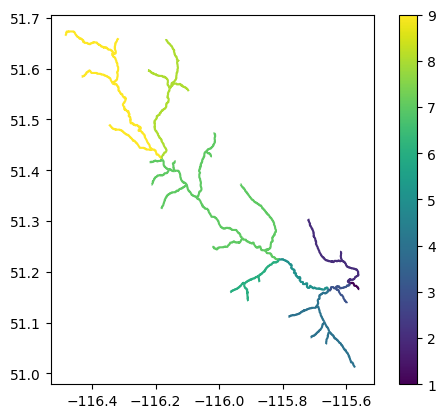

In [57]:
riv_slice = riv[riv['pfaf_temp']==9]

riv_slice = pfaf_one_round(riv_slice)

# # Create a new figure and axes
fig, ax = plt.subplots()

# Plot the first river GeoDataFrame
riv_slice.plot(column='pfaf_temp', cmap='viridis', legend=True, ax=ax)

riv.to_file('./output/stations_merit_riv_pfaf_9.shp')

In [51]:
import numpy as np

# Example NumPy arrays
seg_ids = np.array([3, 2, 1, 4, 5])
pfaf_codes = np.array([100, 200, 300, 400, 500])

# Zip the arrays
zipped = zip(seg_ids, pfaf_codes)

# Sort the zipped list based on seg_ids (first element of each tuple)
sorted_zipped = sorted(zipped, key=lambda x: x[0], reverse=True)

# Unzip the sorted zipped list
sorted_seg_ids, sorted_pfaf_codes = zip(*sorted_zipped)

print("Sorted seg_ids:", sorted_seg_ids)
print("Sorted pfaf_codes:", sorted_pfaf_codes)

Sorted seg_ids: (5, 4, 3, 2, 1)
Sorted pfaf_codes: (500, 400, 100, 200, 300)


In [10]:
np.arange(1, 2)

array([1])